# Part2 - Analyze the data and build Baseline models and compare

In [3]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from sklearn import metrics
import tensorflow_hub as hub
import os
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from xgboost import XGBRegressor
from matplotlib import pyplot
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LinearRegression
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
df_train_with_text = pd.read_csv("train_data_cleaned.csv",lineterminator='\n')
df_test_with_text = pd.read_csv("test_data_cleaned.csv",lineterminator='\n')

df_train_with_text['text_cleaned'] = df_train_with_text['text_cleaned'].astype(str)
df_test_with_text['text_cleaned'] = df_test_with_text['text_cleaned'].astype(str)

df_train_with_text[['cluster_size','katz']]=(df_train_with_text[['cluster_size','katz']] - df_train_with_text[['cluster_size','katz']].mean()) / df_train_with_text[['cluster_size','katz']].std()
df_test_with_text[['cluster_size','katz']]=(df_test_with_text[['cluster_size','katz']] - df_test_with_text[['cluster_size','katz']].mean()) / df_test_with_text[['cluster_size','katz']].std()

df_train_with_text.shape, df_test_with_text.shape

((174241, 18), (43560, 18))

In [ ]:
df_train_with_text.head(2)

,author,hindex,cluster_num,cluster_size,min_neigh_index,max_neigh_index,mean_neigh_index,std_neigh_index,pagerank,katz,hits,degree,core_number,author_total_papers,average_neigbour_degree,cluster_of_node,approx_betweeness_centrality,text_cleaned
0,1964267543,4.0,23,-0.922119,11.0,39.0,21.8,10.24,0.0,-0.093057,0.0,5,5,5,22.8,1.0,0.0,there is little information from independent ...
1,2153592714,13.0,4,0.188785,20.0,20.0,20.0,0.00,0.0,-0.093058,0.0,2,2,5,10.0,1.0,0.0,a method of and wireless communications unit ...


# 1. Feature selection and Extraction

In [ ]:
#we do have following features
total_numerical_features = ['cluster_num','cluster_size','min_neigh_index','max_neigh_index','mean_neigh_index','std_neigh_index','pagerank','katz','hits','degree','core_number','author_total_papers','average_neigbour_degree','cluster_of_node','approx_betweeness_centrality']
len(total_numerical_features)

15

## 1.1 Feature selection using xgboost
To see what features had the highest impact on our model we tested the feature importance with the help of xgboost


[00:47:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


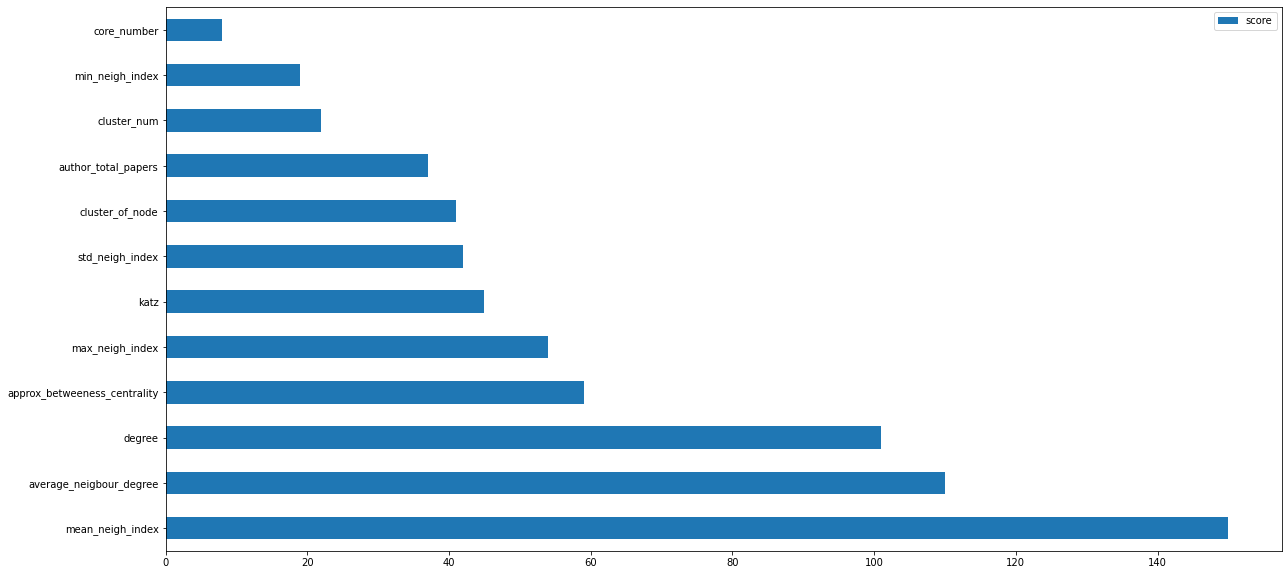

In [ ]:
model = XGBRegressor()
model.fit(df_train_with_text[total_numerical_features], df_train_with_text['hindex'])

# get importance
importance = model.feature_importances_

feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

## 1.2 Feature selection using Permutation

In [ ]:
def base_model():
    model = tf.keras.Sequential()        
    model.add(layers.Dense(24, activation="relu"))
    model.add(layers.Dense(1))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="mse",
                metrics=["mse"])
    return model

X_perm = df_train_with_text[total_numerical_features]
y_perm = df_train_with_text["hindex"]

my_model = KerasRegressor(build_fn=base_model, epochs=1, batch_size=64, verbose=0)    
my_model.fit(X_perm,y_perm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


2723/2723 [==============================] - 7s 2ms/step - loss: 95.7855 - mse: 95.7855


In [ ]:
perm = PermutationImportance(my_model, random_state=1).fit(X_perm,y_perm)

2723/2723 [==============================] - 5s 2ms/step - loss: 86.1872 - mse: 86.1872


In [ ]:
eli5.show_weights(perm, feature_names = X_perm.columns.tolist())

Weight,Feature
520.1018 ± 2.0188,degree
72.3682 ± 1.3707,average_neigbour_degree
62.4198 ± 0.2755,mean_neigh_index
49.3760 ± 0.7392,max_neigh_index
46.4497 ± 0.5162,core_number
39.4614 ± 0.1031,min_neigh_index
27.0099 ± 0.2252,std_neigh_index
7.8818 ± 0.1074,author_total_papers
2.7250 ± 0.0836,cluster_of_node
0.7176 ± 0.1108,cluster_num


### 1.3 Simple heatmap

In [ ]:

cols_for_seaboen = total_numerical_features
cols_for_seaboen.append("hindex")
scaler = MinMaxScaler()
df_seaborn = scaler.fit_transform(df_train_with_text[cols_for_seaboen])
sns.heatmap(df_seaborn, annot=True, annot_kws={"size": 7})

# 2. Section 2: model tuning and comparison

In [ ]:
# textual info
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2")

In [ ]:
%%time
df_train_with_text['embeddings'] = df_train_with_text['text_cleaned'].apply(lambda x: list(embed([x]).numpy()[0]))

CPU times: user 5min 28s, sys: 32.8 s, total: 6min 1s
Wall time: 4min 16s


In [ ]:
X_train_embed =pd.DataFrame(df_train_with_text['embeddings'].to_list(),columns=[f"embed_{i}" for i in range(50)])
X_train_embed.head(2)

,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,embed_10,embed_11,embed_12,embed_13,embed_14,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20,embed_21,embed_22,embed_23,embed_24,embed_25,embed_26,embed_27,embed_28,embed_29,embed_30,embed_31,embed_32,embed_33,embed_34,embed_35,embed_36,embed_37,embed_38,embed_39,embed_40,embed_41,embed_42,embed_43,embed_44,embed_45,embed_46,embed_47,embed_48,embed_49
0,1.279402,0.024423,1.205214,0.752380,-1.845652,-0.490382,0.067278,1.182670,-1.336800,-0.949518,-1.680692,1.734823,0.128855,-1.242288,-0.471396,-0.624386,0.546875,-1.046683,0.979324,-0.271682,-1.127346,0.002716,2.095275,-0.589165,-0.546988,0.425873,-1.227164,0.833365,0.478775,-1.603880,0.213291,0.191793,0.764764,-1.953609,-0.397252,-1.551973,0.717166,-1.606992,0.434090,-1.127171,0.300641,0.309326,0.258701,1.624037,0.717038,-1.462268,-0.010871,-0.642096,1.902465,1.240712
1,0.805808,0.226699,1.689624,0.427469,-1.852118,-0.771103,0.559913,0.488967,-2.127743,-0.076072,-2.020582,1.830369,-0.265993,-1.326413,0.533834,-0.275428,-0.240341,-1.075429,0.941658,0.314844,-0.566455,-0.010443,1.597429,-0.157713,-0.748630,0.667583,-0.709675,0.180236,0.532144,-1.155452,0.242614,-0.166041,0.384745,-1.747006,-0.603364,-1.233510,0.801233,-1.160883,0.006756,-1.246634,0.118959,0.791461,-0.024860,1.947700,0.221133,-1.477336,-0.108513,-0.752929,1.556847,1.265600


In [ ]:
df_train_with_text_with_embed = pd.concat([df_train_with_text, X_train_embed], axis=1)
df_train_with_text_with_embed.head(2)

,author,hindex,cluster_num,cluster_size,min_neigh_index,max_neigh_index,mean_neigh_index,std_neigh_index,pagerank,katz,hits,degree,core_number,author_total_papers,average_neigbour_degree,cluster_of_node,approx_betweeness_centrality,text_cleaned,embeddings,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,embed_10,embed_11,embed_12,embed_13,embed_14,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20,embed_21,embed_22,embed_23,embed_24,embed_25,embed_26,embed_27,embed_28,embed_29,embed_30,embed_31,embed_32,embed_33,embed_34,embed_35,embed_36,embed_37,embed_38,embed_39,embed_40,embed_41,embed_42,embed_43,embed_44,embed_45,embed_46,embed_47,embed_48,embed_49
0,1964267543,4.0,23,1590,11.0,39.0,21.8,10.24,0.0,1780.12,0.0,5,5,5,22.8,1.0,0.0,there is little information from independent ...,"[1.2794019, 0.024423253, 1.2052135, 0.7523803,...",1.279402,0.024423,1.205214,0.752380,-1.845652,-0.490382,0.067278,1.182670,-1.336800,-0.949518,-1.680692,1.734823,0.128855,-1.242288,-0.471396,-0.624386,0.546875,-1.046683,0.979324,-0.271682,-1.127346,0.002716,2.095275,-0.589165,-0.546988,0.425873,-1.227164,0.833365,0.478775,-1.603880,0.213291,0.191793,0.764764,-1.953609,-0.397252,-1.551973,0.717166,-1.606992,0.434090,-1.127171,0.300641,0.309326,0.258701,1.624037,0.717038,-1.462268,-0.010871,-0.642096,1.902465,1.240712
1,2153592714,13.0,4,11929,20.0,20.0,20.0,0.00,0.0,234.44,0.0,2,2,5,10.0,1.0,0.0,a method of and wireless communications unit ...,"[0.8058079, 0.2266987, 1.6896237, 0.427469, -1...",0.805808,0.226699,1.689624,0.427469,-1.852118,-0.771103,0.559913,0.488967,-2.127743,-0.076072,-2.020582,1.830369,-0.265993,-1.326413,0.533834,-0.275428,-0.240341,-1.075429,0.941658,0.314844,-0.566455,-0.010443,1.597429,-0.157713,-0.748630,0.667583,-0.709675,0.180236,0.532144,-1.155452,0.242614,-0.166041,0.384745,-1.747006,-0.603364,-1.233510,0.801233,-1.160883,0.006756,-1.246634,0.118959,0.791461,-0.024860,1.947700,0.221133,-1.477336,-0.108513,-0.752929,1.556847,1.265600


In [ ]:
"""
1. split data into training and validation
"""
from sklearn.model_selection import train_test_split

X = df_train_with_text_with_embed
y = df_train_with_text_with_embed["hindex"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(139392, 69) (139392,) (34849, 69) (34849,)


In [ ]:
# numerical features and textual features
#train data
num_columns_to_use = list(set( ['degree','core_number','author_total_papers','average_neigbour_degree','cluster_of_node','std_neigh_index','mean_neigh_index']) | set(list(df_train_with_text_with_embed.columns[19:])))
numerical_train_data = X_train[num_columns_to_use].values
y_train = y_train.values

#valid data
numerical_val_data = X_val[num_columns_to_use].values
y_valid = y_val.values


print("train:",numerical_train_data.shape,  y_train.shape)
print("valid:",numerical_val_data.shape,  y_valid.shape)


train: (139392, 57) (139392,)
valid: (34849, 57) (34849,)


In [ ]:


def scaling(train_data,test_data):
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)
    return train_data_scaled, test_data_scaled


def models_score(model_name,train_data, y_train, val_data,y_val,is_transformed=False):
    train_data_scaled, valid_data_scaled = scaling(train_data,val_data)
    train_data_y, val_data_y = y_train, y_val
    model_list = ["random_forest","linear_regression","laso"]
    
    #model_1
    if model_name=="random_forest":
        reg = RandomForestRegressor(random_state=42)
        
    #model_2
    elif model_name=="linear_regression":
        reg = LinearRegression()
        
    #model_3
    elif model_name=="laso":
        reg = Lasso(alpha=0.1)
        
    #model_4
    elif model_name=="NN":
        model = tf.keras.Sequential([
            layers.Dense(36,activation="relu"),
            layers.Dense(1),
        ])
        model.compile(loss="mse",optimizer=tf.keras.optimizers.Adam())
        model.fit(train_data_scaled,train_data_y,epochs=5,verbose=0)
        pred = tf.squeeze(model.predict(valid_data_scaled),axis=1)
        if is_transformed==True:
            score = mean_squared_error(np.exp(pred), val_data_y)
        else:
            score = mean_squared_error(pred, val_data_y)
        return score
    else:
        print("please enter correct regressor name")
        
    if model_name in model_list:
        reg.fit(train_data_scaled,train_data_y)
        pred = reg.predict(valid_data_scaled)
        if is_transformed==True:
            score = mean_squared_error(np.exp(pred), val_data_y)
        else:
            score = mean_squared_error(pred, val_data_y)
        return score

In [ ]:
model_list = ["random_forest","linear_regression","laso","NN"]
result_scores = []
for model in model_list:
    score = models_score(model,numerical_train_data,y_train, numerical_val_data,y_val)
    result_scores.append((model,score))
    print(model,score)

random_forest 60.65194444701347
linear_regression 85.9662106725949
laso 99.0102282267456
NN 88.07711884210538


## log transformation - for imbalanced target variable

In [ ]:
df_result_scores = pd.DataFrame(result_scores,columns=["model","mse"])
df_result_scores

,model,mse
0,random_forest,60.651944
1,linear_regression,85.966211
2,laso,99.010228
3,NN,88.077119


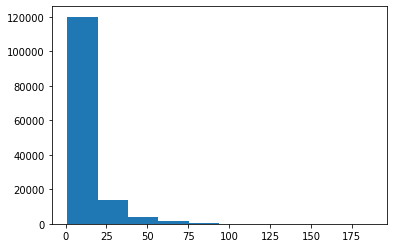

In [ ]:
# cope with imbalanced regression task
plt.hist(y_train)
plt.show()

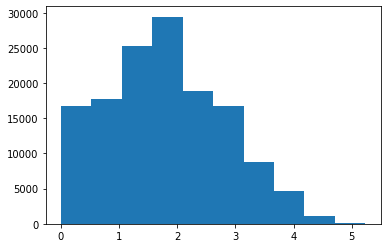

In [ ]:
transformations = "log"
y_train_transformed = np.log(y_train)
plt.hist(y_train_transformed)
plt.show()

In [ ]:
model_list = ["random_forest","linear_regression","laso","NN"]
result_scores_transformed = []
for model in model_list:
    score = models_score(model,numerical_train_data,y_train_transformed, numerical_val_data,y_val, is_transformed = True)
    result_scores_transformed.append((model,score))
    print(model,score)

random_forest 65.6400772293353
linear_regression 150.47147957867293
laso 164.60794581952308
NN 77.05680693128079


In [ ]:
df_result_scores_transformed = pd.DataFrame(result_scores_transformed,columns=["model","mse_with_y_log"])
df_result_scores_transformed

,model,mse_with_y_log
0,random_forest,65.640077
1,linear_regression,150.471480
2,laso,164.607946
3,NN,77.056807


In [ ]:
compare_df = pd.merge(df_result_scores,df_result_scores_transformed,on=["model"])
compare_df

,model,mse,mse_with_y_log
0,random_forest,60.651944,65.640077
1,linear_regression,85.966211,150.471480
2,laso,99.010228,164.607946
3,NN,88.077119,77.056807
